# Benchmarking

# Using QPCA class

In [1]:
from QPCA.decomposition.Qpca import QPCA
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from QPCA.preprocessingUtilities.preprocessing_matrix_utilities import generate_matrix

In [2]:
resolution=8
matrix_dimension=4
lista=list(range(0,2**resolution))
eigenvalues_list=random.sample(lista,matrix_dimension)
eigenvalues_list

[113, 127, 12, 106]

In [4]:
eigenvalues_list=[0.6,0.3,0.06,0.04]

In [5]:
#16
#856
#4747
#543
#6734
seed=4747
input_matrix=generate_matrix(matrix_dimension=matrix_dimension,replicate_paper=False,seed=seed,eigenvalues_list=eigenvalues_list)

Matrix:
 [[0.12 0.02 0.05 0.14]
 [0.02 0.33 0.16 0.08]
 [0.05 0.16 0.17 0.16]
 [0.14 0.08 0.16 0.38]]

eigenvalue: 0.04000000000000001 - eigenvector: [ 0.23  -0.357  0.812 -0.4  ]
eigenvalue: 0.05999999999999998 - eigenvector: [-0.882 -0.207  0.303  0.295]
eigenvalue: 0.3000000000000001 - eigenvector: [-0.304  0.772  0.163 -0.534]
eigenvalue: 0.6000000000000001 - eigenvector: [-0.277 -0.483 -0.471 -0.685]


In [6]:
qpca=QPCA().fit(input_matrix,resolution=resolution)

In [7]:
np.linalg.eig(qpca.input_matrix)

(array([0.6 , 0.3 , 0.06, 0.04]),
 array([[-0.27669967, -0.30381059, -0.88229208,  0.2295585 ],
        [-0.48274483,  0.77216236, -0.20746302, -0.35732594],
        [-0.47083591,  0.16297368,  0.30291613,  0.81240073],
        [-0.68462272, -0.53376399,  0.29455322, -0.39953239]]))

In [8]:
np.linalg.eig(qpca.input_matrix),qpca.input_matrix

((array([0.6 , 0.3 , 0.06, 0.04]),
  array([[-0.27669967, -0.30381059, -0.88229208,  0.2295585 ],
         [-0.48274483,  0.77216236, -0.20746302, -0.35732594],
         [-0.47083591,  0.16297368,  0.30291613,  0.81240073],
         [-0.68462272, -0.53376399,  0.29455322, -0.39953239]])),
 array([[0.12244213, 0.01746936, 0.05473825, 0.14304831],
        [0.01746936, 0.32638568, 0.1587465 , 0.07669711],
        [0.05473825, 0.1587465 , 0.17288529, 0.15968041],
        [0.14304831, 0.07669711, 0.15968041, 0.3782869 ]]))

In [9]:
original_eigenvectors=np.linalg.eig(qpca.input_matrix)[1]
original_eigenvalues=np.linalg.eig(qpca.input_matrix)[0]

k = original_eigenvalues.argsort()[::-1]   
original_eigenvalues = original_eigenvalues[k]
original_eigenvectors = original_eigenvectors[:,k]
original_eigenvectors

array([[-0.27669967, -0.30381059, -0.88229208,  0.2295585 ],
       [-0.48274483,  0.77216236, -0.20746302, -0.35732594],
       [-0.47083591,  0.16297368,  0.30291613,  0.81240073],
       [-0.68462272, -0.53376399,  0.29455322, -0.39953239]])

In [10]:
original_eigenvalues*qpca.input_matrix_trace

array([0.6 , 0.3 , 0.06, 0.04])

We see how the l2 distance between the reconstructed vector and the original one decreases, when we increase the number of shots of the tomography

In [11]:
shots_numbers=[100,500,1500,10000,100000,500000,1000000]

/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/tommasofioravanti/Desktop/Intesa/Quantum/Esperimenti/QuPCA/QPCA/postprocessingUtilities/postprocessing_eig_reconstruction.py:85: RuntimeWarning: invalid value encountered in divide
  scaled_statevectors.append(statevector[i:i+len_input_matrix]/max_list[e])


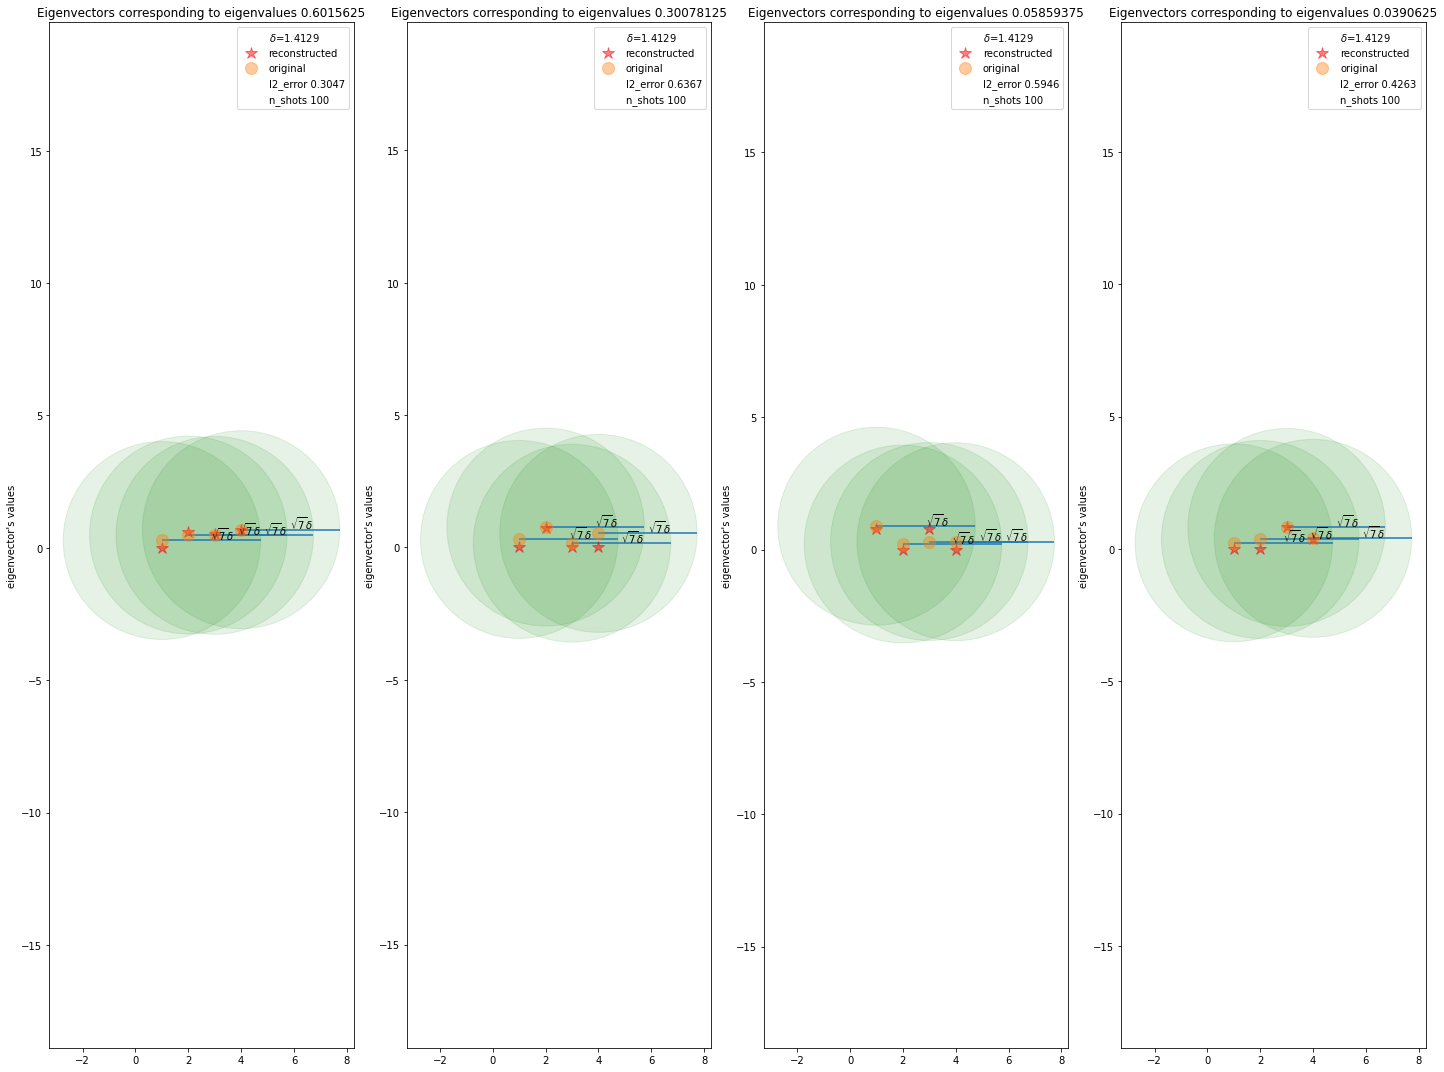

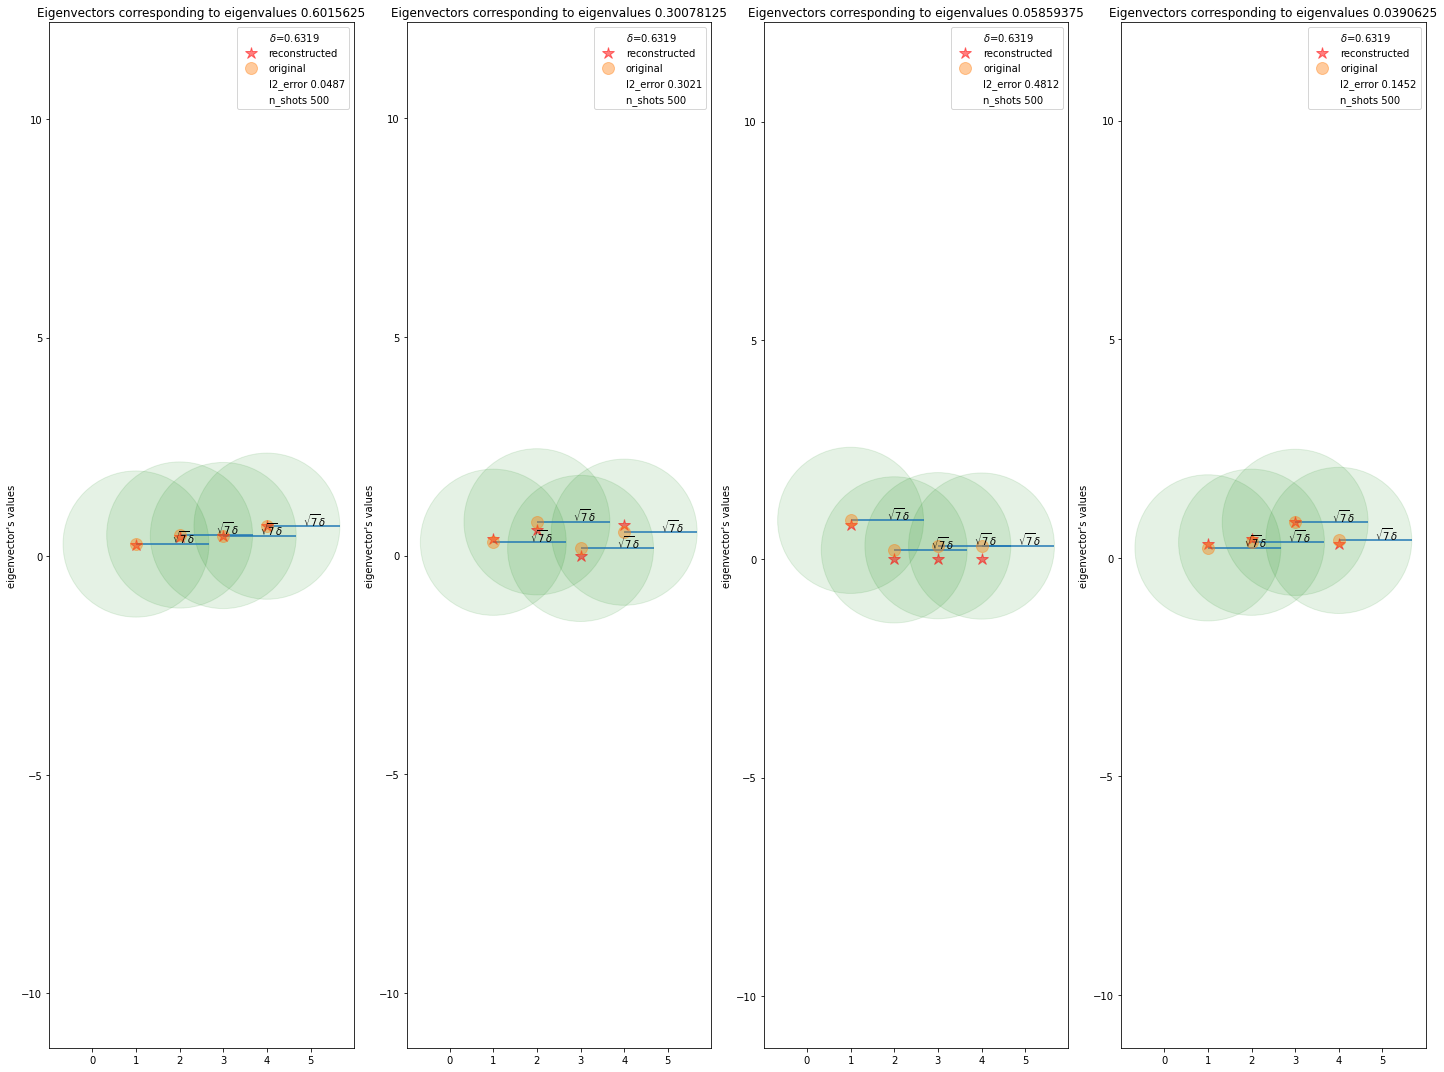

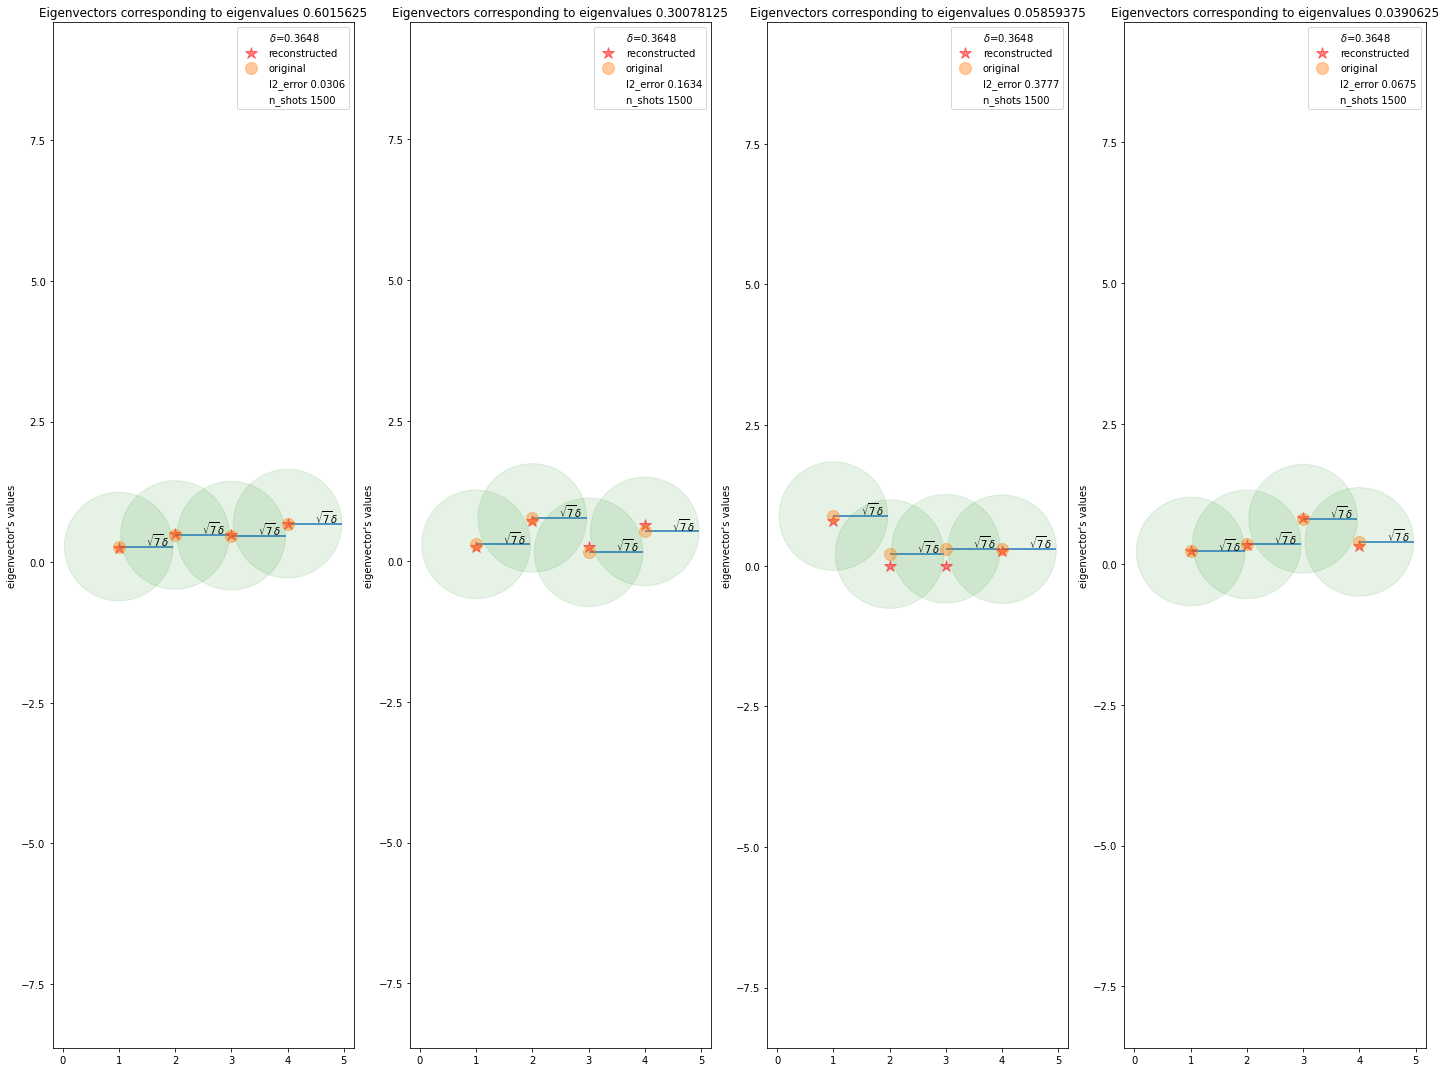

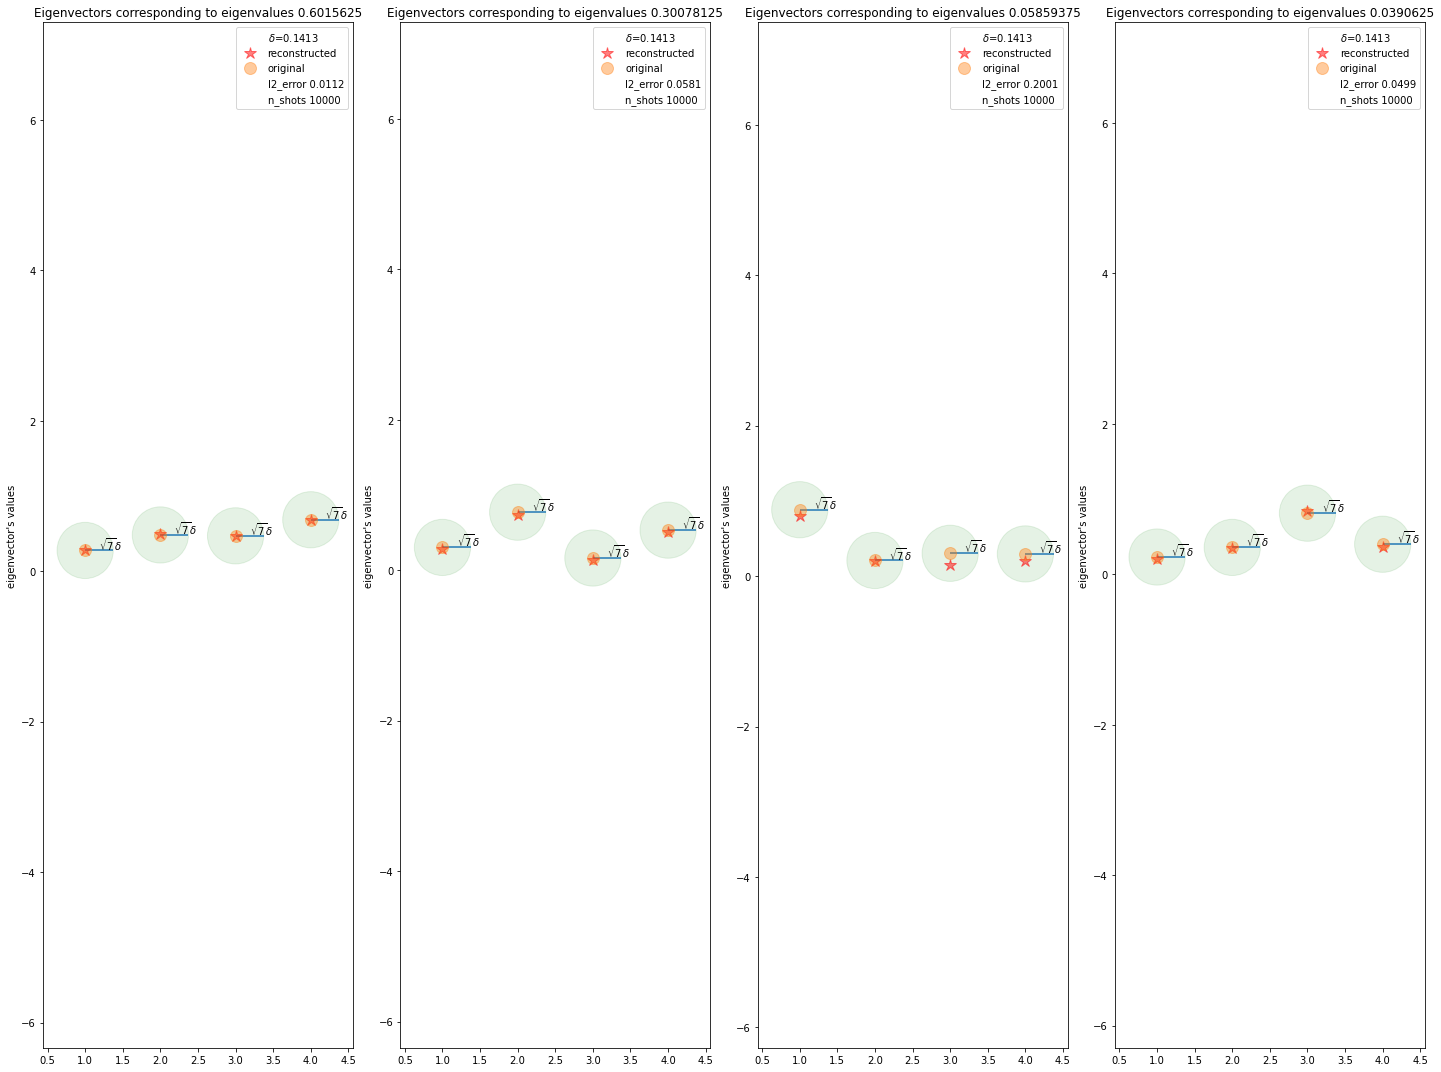

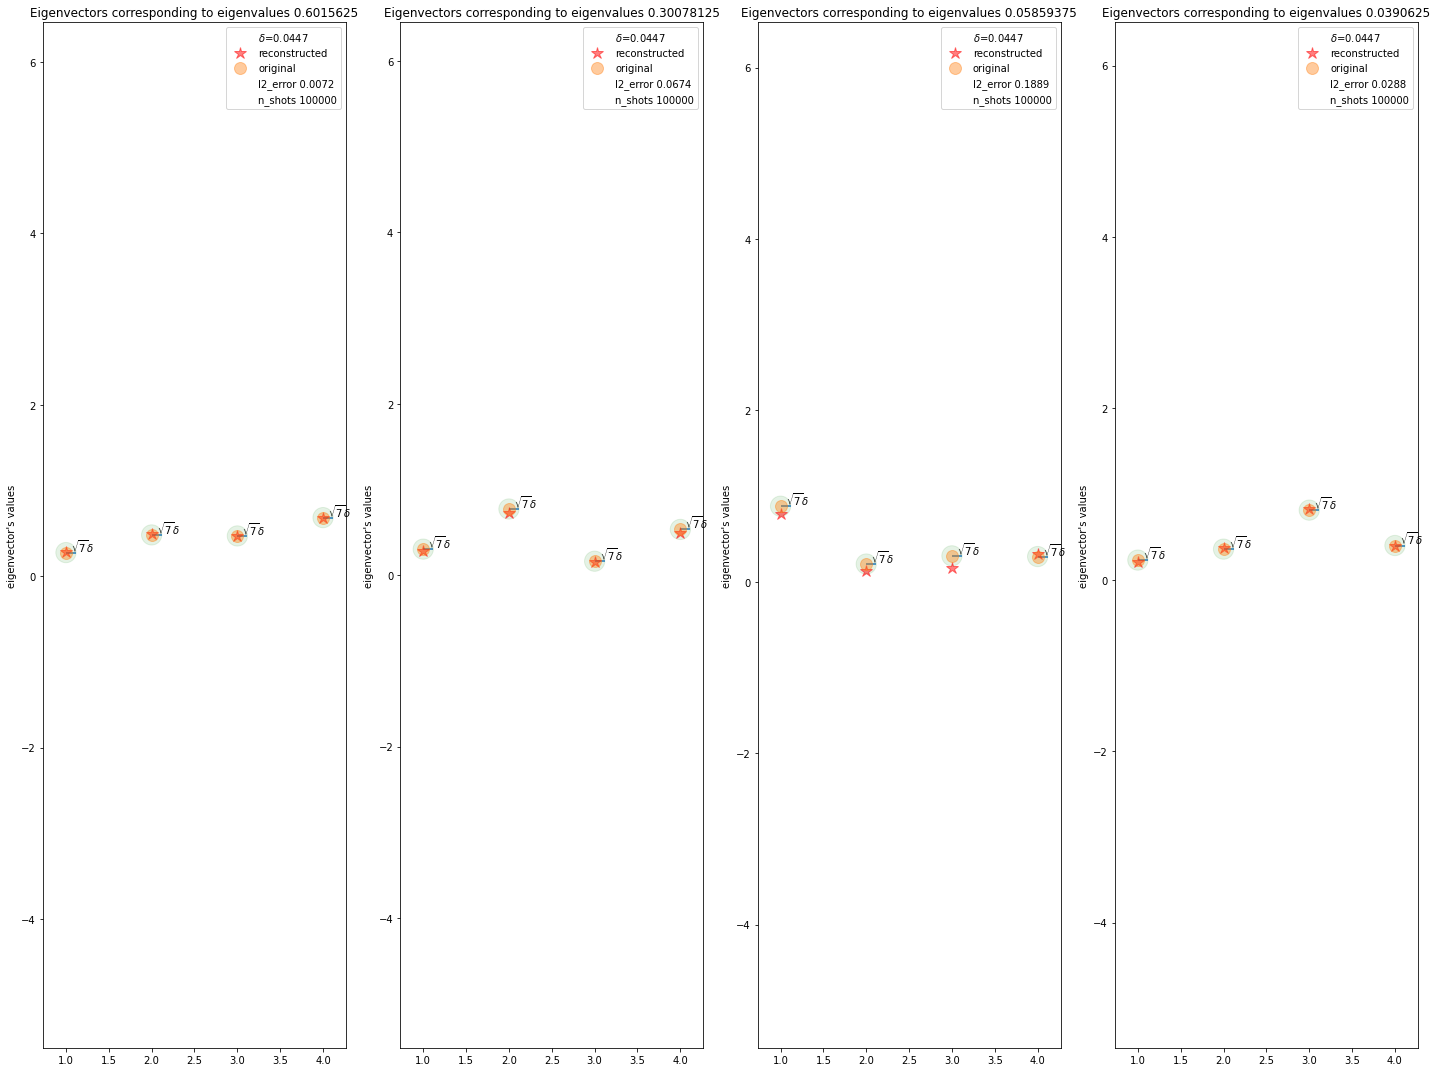

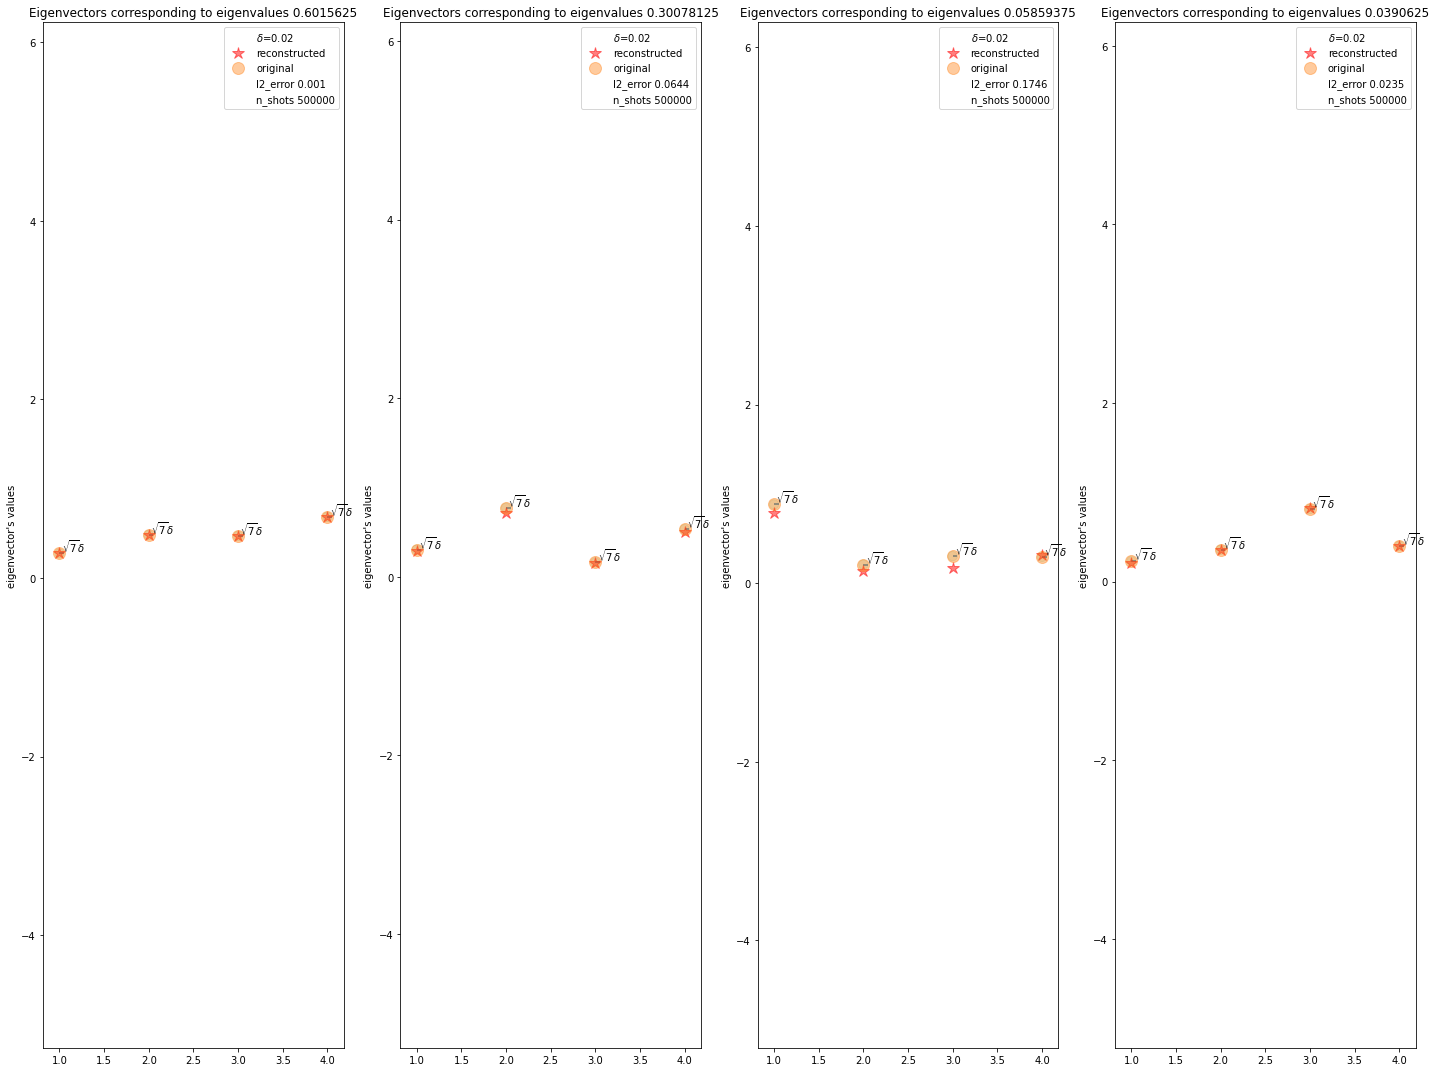

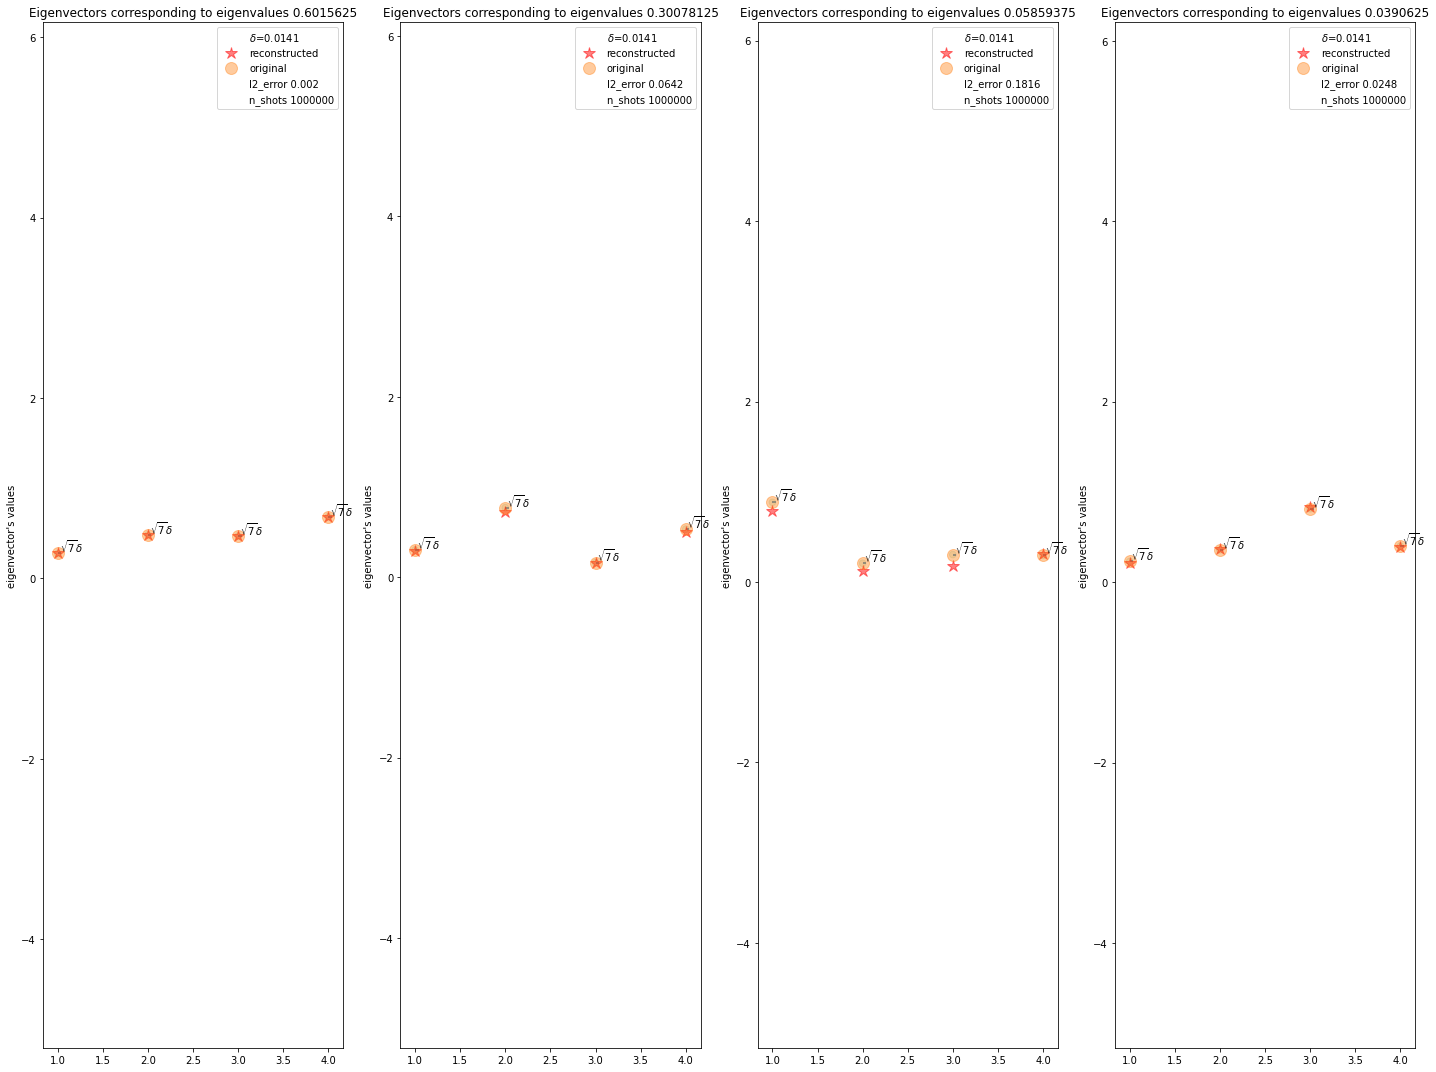

In [12]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

error_list=[]
delta_list=[]
matrix_idx=17
for s in shots_numbers:
    number_of_errors=np.zeros(len(input_matrix))
    number_of_errors[:]=np.nan
    
    reconstructed_ev=np.empty((len(input_matrix),len(input_matrix)))
    reconstructed_ev[:] = np.nan
    idx=[]
    
    reconstructed_eigenvectors=qpca.eigenvectors_reconstruction(n_shots=s,n_repetitions=1)
    eigenvalues=np.array([i[0] for i in reconstructed_eigenvectors])
    eigenvectors=[i[1] for i in reconstructed_eigenvectors]
    
    eig_evec_tuple,delta=qpca.spectral_benchmarking(eigenvector_benchmarking=True, eigenvalues_benchmarching=False,print_distances=True,only_first_eigenvectors=False,plot_delta=True,distance_type='l2',error_with_sign=False)
    error_list.append(eig_evec_tuple)
    delta_list.append(delta)
    
    for e in eig_evec_tuple:
        x=find_nearest(original_eigenvalues,e[0])
        if x not in idx:
            idx.append(x)
            reconstructed_ev[x]=[r[1] for r in reconstructed_eigenvectors if r[0]==e[0]][0]
            number_of_errors[x]=e[1]

    dict_={'matrix_idx':matrix_idx,'seed':seed,'eigenvalues':original_eigenvalues*qpca.input_matrix_trace,'reconstructed_eigenvalues':np.array(sorted(eigenvalues,reverse=True))*qpca.input_matrix_trace,'1st_original_eigenvector':original_eigenvectors[:,0],'2nd_original_eigenvector':original_eigenvectors[:,1],'3th_original_eigenvector':original_eigenvectors[:,2],'4th_original_eigenvector':original_eigenvectors[:,3],
       '1st_reconstructed_eigenvector':reconstructed_ev[0],'2nd_reconstructed_eigenvector':reconstructed_ev[1],'3th_reconstructed_eigenvector':reconstructed_ev[2],'4th_reconstructed_eigenvector':reconstructed_ev[3],
           'n_shots':s,'l2_error_first_eig':number_of_errors[0],'l2_error_second_eig':number_of_errors[1],'l2_error_third_eig':number_of_errors[2],'l2_error_fourth_eig':number_of_errors[3],'delta_error':delta}
        

    #df_=df_.append(dict_,ignore_index=True,sort=False)


In [13]:
for s in shots_numbers:
    reconstructed_eigenvectors=qpca.eigenvectors_reconstruction(n_shots=s,n_repetitions=1)
    print('\n')
    print('Number of shots: ',s )
    qpca.spectral_benchmarking(eigenvector_benchmarking=False, eigenvalues_benchmarching=False,sign_benchmarking=True,print_distances=True,only_first_eigenvectors=False,plot_delta=True,distance_type='l2',error_with_sign=False)



Number of shots:  100
+------------+--------------+------------+
| Eigenvalue | correct_sign | wrong_sign |
+============+==============+============+
| 0.600      | 2            | 2          |
+------------+--------------+------------+
| 0.300      | 4            | 0          |
+------------+--------------+------------+
| 0.040      | 2            | 2          |
+------------+--------------+------------+


Number of shots:  500
+------------+--------------+------------+
| Eigenvalue | correct_sign | wrong_sign |
+============+==============+============+
| 0.600      | 4            | 0          |
+------------+--------------+------------+
| 0.300      | 4            | 0          |
+------------+--------------+------------+
| 0.060      | 3            | 1          |
+------------+--------------+------------+
| 0.040      | 3            | 1          |
+------------+--------------+------------+


Number of shots:  1500
+------------+--------------+------------+
| Eigenvalue | correct_s

Number of shots:  100




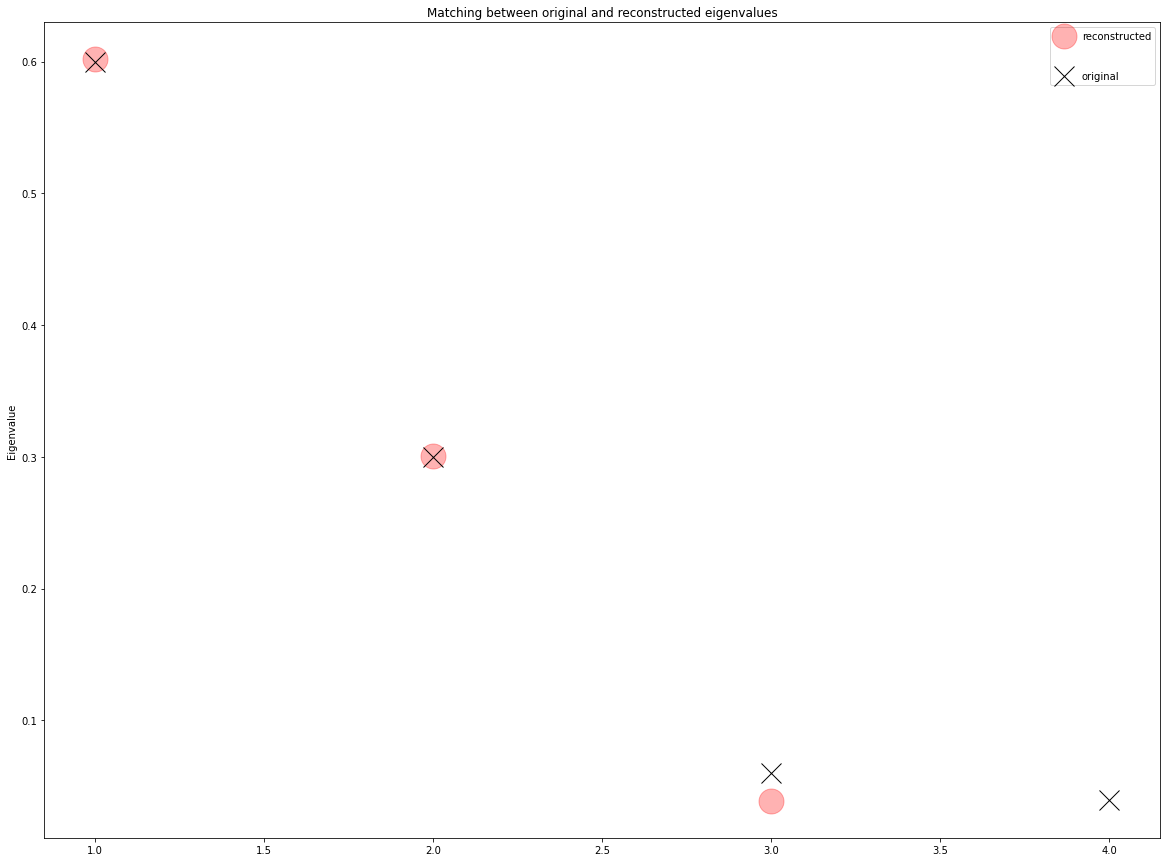

Number of shots:  500




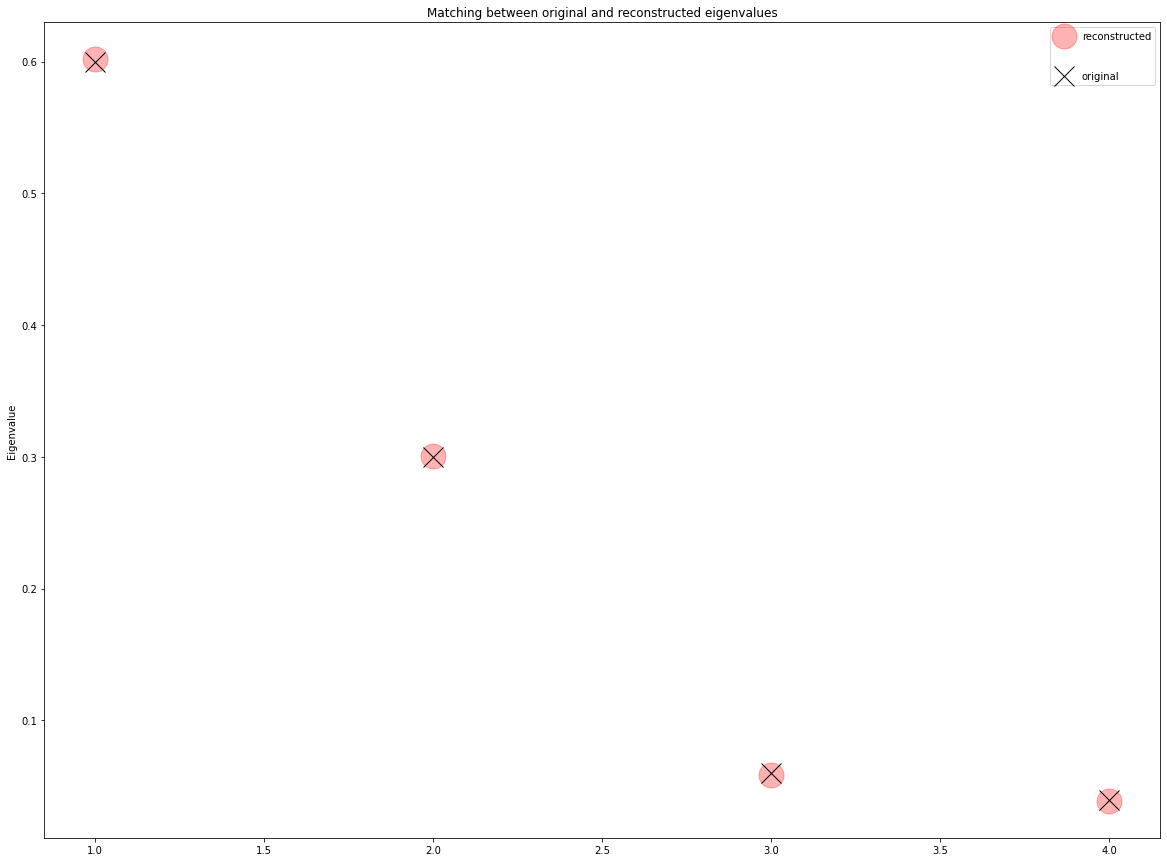

Number of shots:  1500




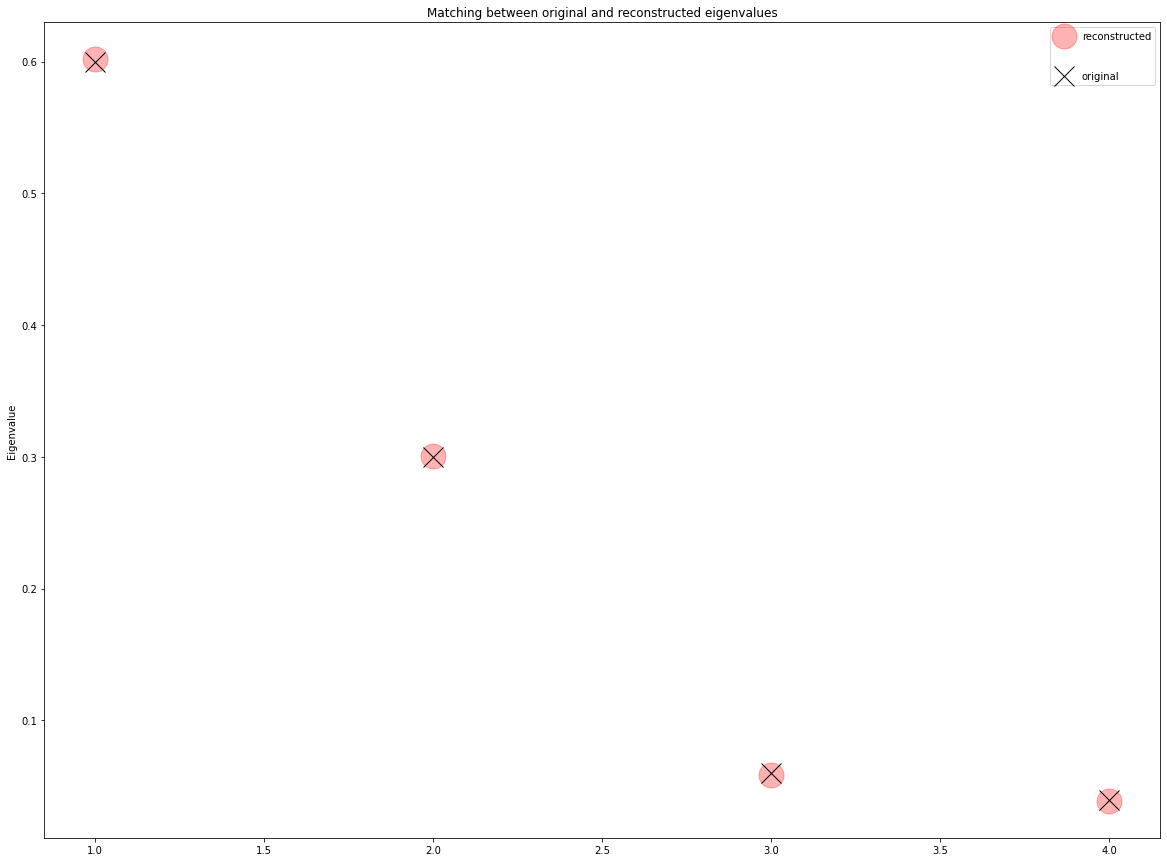

Number of shots:  10000




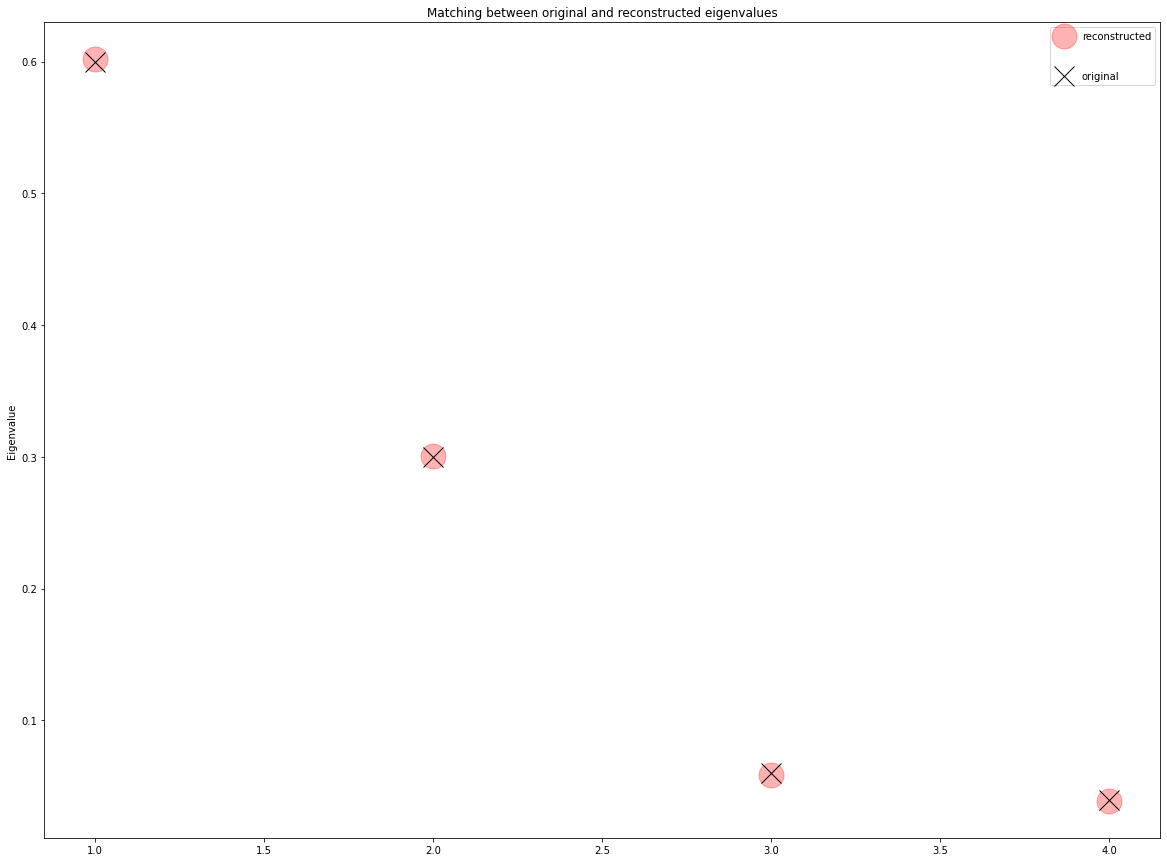

Number of shots:  100000




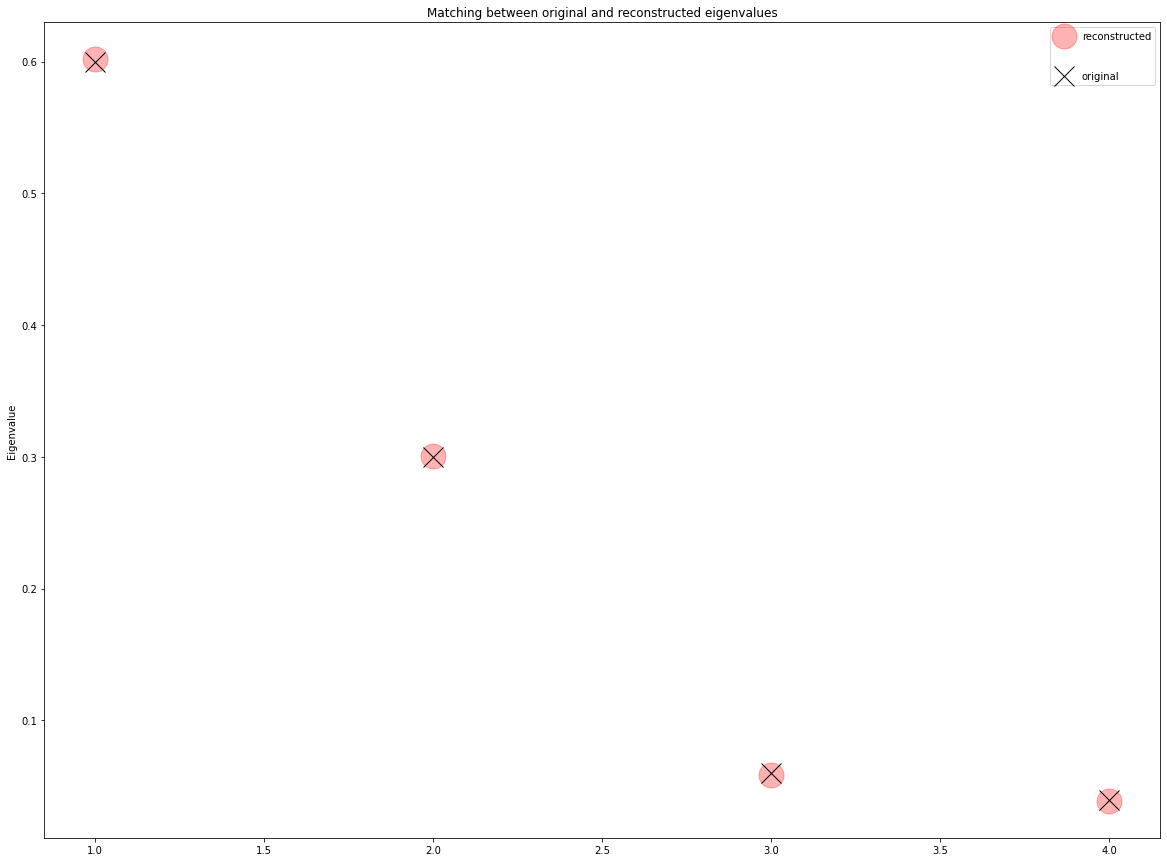

Number of shots:  500000




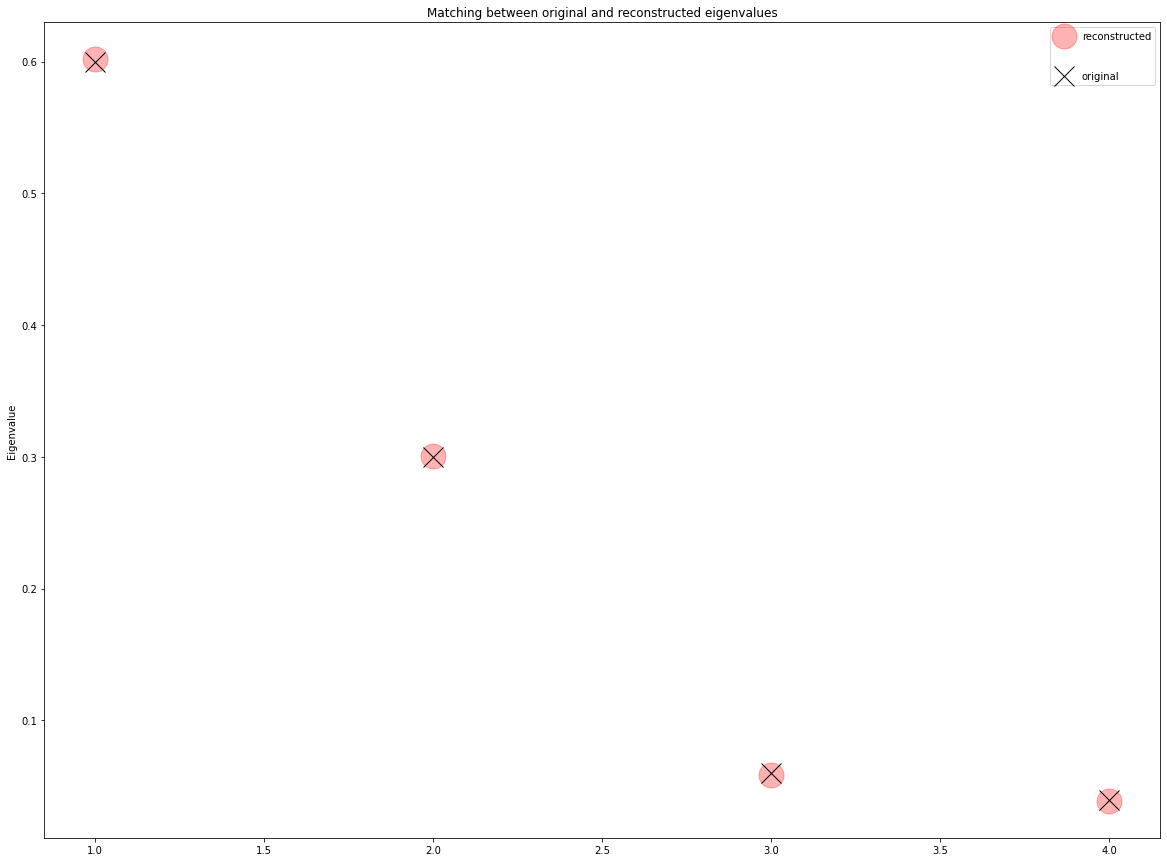

Number of shots:  1000000




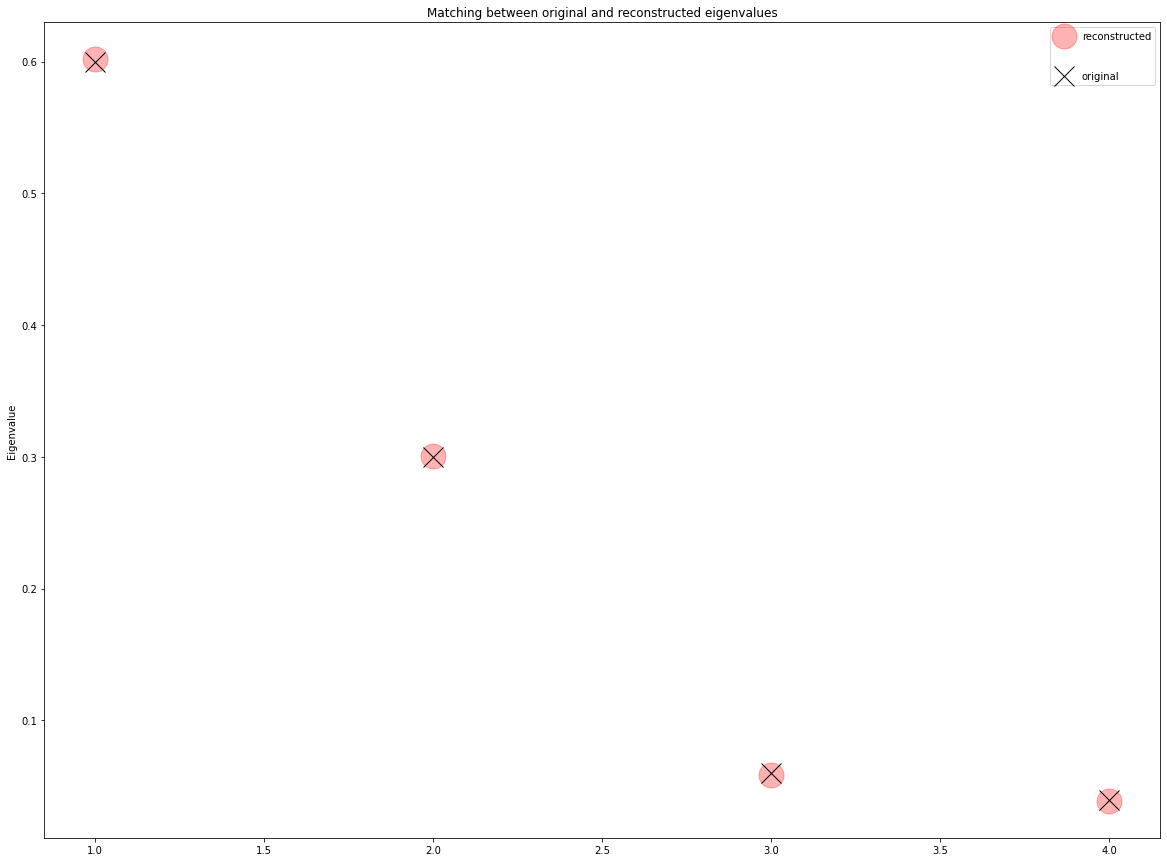

In [14]:
for s in shots_numbers:
    reconstructed_eigenvectors=qpca.eigenvectors_reconstruction(n_shots=s,n_repetitions=1)
    print('Number of shots: ',s )
    print('\n')
    qpca.spectral_benchmarking(eigenvector_benchmarking=False, eigenvalues_benchmarching=True,sign_benchmarking=False,print_distances=True,only_first_eigenvectors=False,plot_delta=True,distance_type='l2',error_with_sign=False)

In [14]:
df_=pd.read_csv('benchmarking2.csv')
df_

,matrix_idx,seed,eigenvalues,1st_original_eigenvector,2nd_original_eigenvector,3th_original_eigenvector,4th_original_eigenvector,1st_reconstructed_eigenvector,2nd_reconstructed_eigenvector,3th_reconstructed_eigenvector,4th_reconstructed_eigenvector,n_shots,l2_error_first_eig,l2_error_second_eig,l2_error_third_eig,l2_error_fourth_eig,delta_error,reconstructed_eigenvalues
0,0,1235,[2. 1.],[0.70710678 0.70710678],[-0.70710678 0.70710678],NaN,NaN,[0.74273392 0.7207658 ],[ 0.78594434 -0.68957161],NaN,NaN,100,0.0382,0.0808,NaN,NaN,0.706446,[2.00390625 0.99609375]
1,0,1235,[2. 1.],[0.70710678 0.70710678],[-0.70710678 0.70710678],NaN,NaN,[0.6999436 0.71374578],[ 0.25482098 -0.76490547],NaN,NaN,500,0.0098,0.4560,NaN,NaN,0.315932,[2.00390625 0.99609375]
2,0,1235,[2. 1.],[0.70710678 0.70710678],[-0.70710678 0.70710678],NaN,NaN,[0.71599535 0.69554272],[-0.72190802 0.69052906],NaN,NaN,1500,0.0146,0.0222,NaN,NaN,0.182404,[2.00390625 0.99609375]
3,0,1235,[2. 1.],[0.70710678 0.70710678],[-0.70710678 0.70710678],NaN,NaN,[0.71026872 0.69831718],[-0.69883241 0.71352511],NaN,NaN,10000,0.0093,0.0105,NaN,NaN,0.070645,[2.00390625 0.99609375]
4,0,1235,[2. 1.],[0.70710678 0.70710678],[-0.70710678 0.70710678],NaN,NaN,[0.70370823 0.70823506],[ 0.7122047 -0.69689864],NaN,NaN,100000,0.0036,0.0114,NaN,NaN,0.022340,[2.00390625 0.99609375]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,17,900,[2.15219952 0.3485604 0.10008155 0.0272474 ],[0.49767392 0.42879739 0.62656256 0.41937194],[ 0.14173162 0.62775433 -0.71859259 0.26355521],[ 0.74992357 -0.04712204 -0.13048335 -0.64681393],[ 0.41212554 -0.64794816 -0.27206277 0.57991169],[0.47767098 0.42943104 0.61243225 0.36660776],[ 0.19501954 0.6755675 -0.80408616 0.25176914],[0.84089642 0. 0. 0. ],[-0.4728708 -0.74767439 -0.33437015 0.74767439],1500,0.0582,0.1121,0.6678,0.2137,0.364807,[2.15585415 0.34904305 0.10265972 0.03079792]
122,17,900,[2.15219952 0.3485604 0.10008155 0.0272474 ],[0.49767392 0.42879739 0.62656256 0.41937194],[ 0.14173162 0.62775433 -0.71859259 0.26355521],[ 0.74992357 -0.04712204 -0.13048335 -0.64681393],[ 0.41212554 -0.64794816 -0.27206277 0.57991169],[0.47886288 0.42250126 0.60947765 0.41862248],[ 0.1643996 0.72330486 -0.77609348 0.27788604],[ 0.44428089 0. 0. -0.85073313],[ 0.37711224 0.8432486 0.37711224 -0.6158217 ],10000,0.0262,0.1147,0.3927,0.2274,0.141289,[2.15585415 0.34904305 0.10265972 0.03079792]
123,17,900,[2.15219952 0.3485604 0.10008155 0.0272474 ],[0.49767392 0.42879739 0.62656256 0.41937194],[ 0.14173162 0.62775433 -0.71859259 0.26355521],[ 0.74992357 -0.04712204 -0.13048335 -0.64681393],[ 0.41212554 -0.64794816 -0.27206277 0.57991169],[0.49131633 0.41811108 0.60827984 0.40802383],[ 0.16699598 0.70769468 -0.78983737 0.28154877],[ 0.78046853 0. -0.08618833 -0.59087742],[-0.46367096 0.80791069 0.36291328 -0.69166672],100000,0.0249,0.1115,0.0908,0.2213,0.044680,[2.15585415 0.34904305 0.10265972 0.03079792]
124,17,900,[2.15219952 0.3485604 0.10008155 0.0272474 ],[0.49767392 0.42879739 0.62656256 0.41937194],[ 0.14173162 0.62775433 -0.71859259 0.26355521],[ 0.74992357 -0.04712204 -0.13048335 -0.64681393],[ 0.41212554 -0.64794816 -0.27206277 0.57991169],[0.48208825 0.41657422 0.6103402 0.40753921],[ 0.15789881 0.70833157 -0.78817913 0.30287255],[ 0.76104164 0. -0.08858909 -0.64005234],[-0.47170823 0.80778239 0.36601523 -0.67626631],500000,0.0282,0.1146,0.0644,0.2173,0.019981,[2.15585415 0.34904305 0.10265972 0.03079792]


In [47]:
df_.to_csv('benchmarking2.csv',index=False)

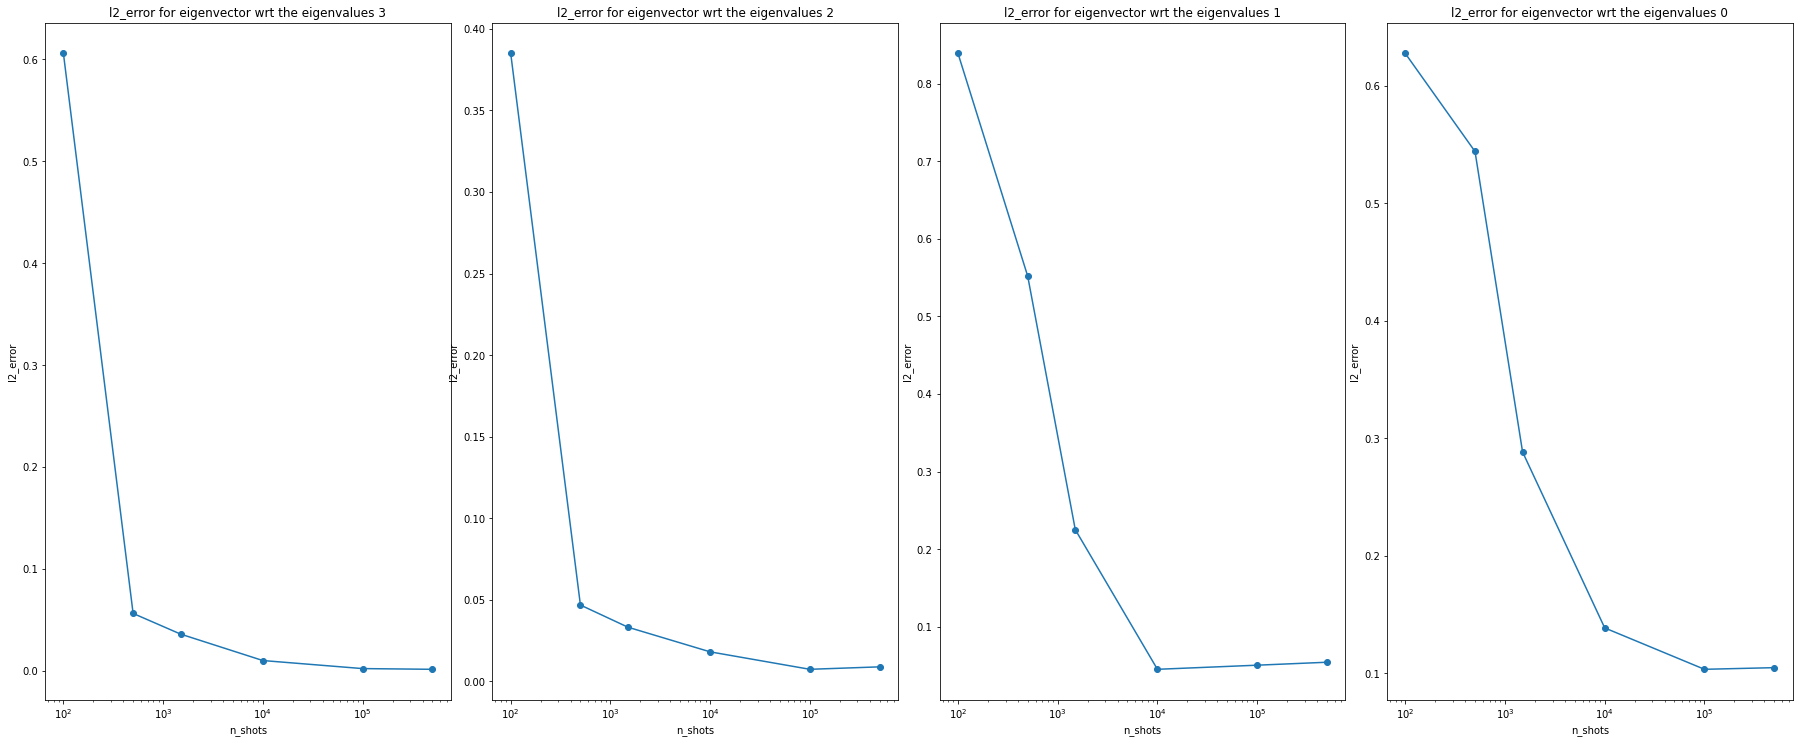

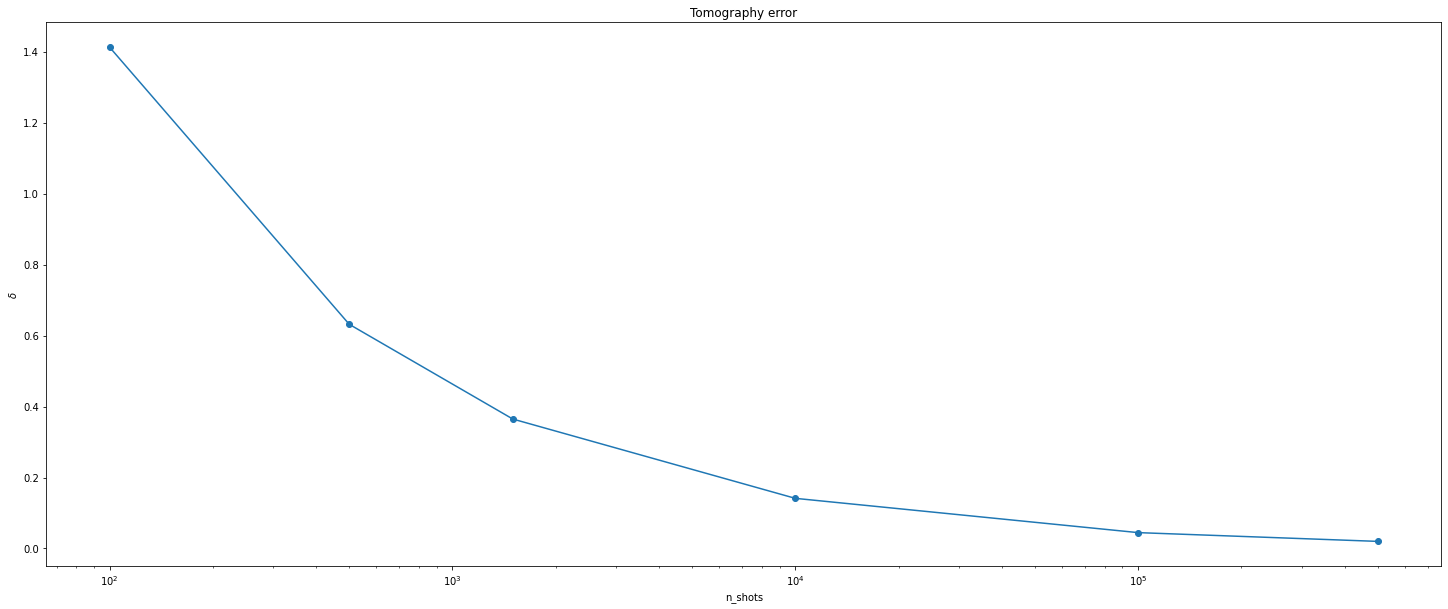

In [53]:
qpca.error_benchmarking(errors_list=error_list,delta_list=delta_list ,shots_list=shots_numbers,n_tomography_repetitions=1,plot_delta=True,distance_type='l2')